In [ ]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import pickle
import librosa
import librosa.display

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn(self.conv1(x)))
        out = self.bn(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out


class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(256),
            nn.Flatten(),
            nn.Linear(256 * 16 * 27, 256),
            nn.ReLU(),
            nn.Linear(256, 64)
        )
        
        self.mu_layer = nn.Linear(64, 32)
        self.logvar_layer = nn.Linear(64, 32)
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 256 * 16 * 27),
            nn.ReLU(),
            nn.Unflatten(1, (256, 16, 27)),
            ResidualBlock(256),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.ReLU(),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.ReLU(),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
            nn.ReLU(),
            ResidualBlock(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(1,0)),
            nn.ReLU(),
            ResidualBlock(16),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=(1,1)),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        reconstructed = self.decoder(z)
        return reconstructed, mu, logvar
    
model = ConvVAE()
state_dict = torch.load('./out/violin/model_1031_0.012112.pt')
model.load_state_dict(state_dict)

In [7]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
# Load audio file
audio_path = '../../data/violin/2241_4.wav'
y, sr = librosa.load(audio_path)

y = librosa.resample(y, orig_sr=sr, target_sr=44100)
sr = 44100

S = librosa.feature.melspectrogram(y=y, n_mels=512, sr=sr, n_fft=1024, hop_length=256)

#############################
specs = torch.tensor(S)
specs = specs.unsqueeze(0)
print(specs.shape)
specs = model(specs)
specs = specs.squeeze(0)
print(specs.shape)
#############################

torch.Size([1, 2049, 108])
torch.Size([1, 219136])


In [ ]:
from IPython.display import Audio

# Display and play the audio
Audio(data=y, rate=sr)

In [ ]:
import numpy as np

stft = librosa.feature.inverse.mel_to_stft(specs.detach().numpy(), sr=sr, n_fft=1024)
print(stft.shape)
y_inv = librosa.griffinlim(stft, hop_length=256)
print(y_inv.shape)


In [ ]:
from IPython.display import Audio

# Display and play the audio
Audio(data=y_inv, rate=sr)

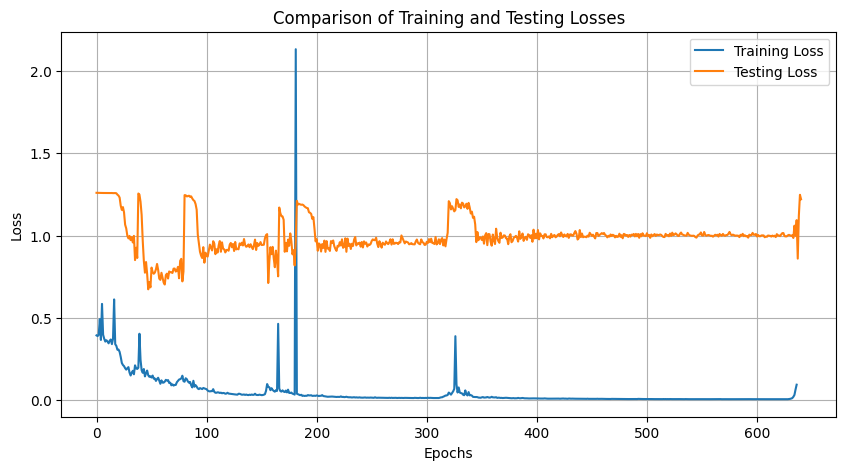

In [12]:
import pickle
import matplotlib.pyplot as plt

# Load data from pickle files
def load_pickle(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

test_loss = load_pickle('./out/violin/test_loss.pkl')
train_loss = load_pickle('./out/violin/train_loss.pkl')
t_loss = []
r_loss = []
for train in train_loss:
    if train <= 5:
        t_loss.append(train)
for train in test_loss:
    if train <= 5:
        r_loss.append(train)
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training Loss')
plt.plot(r_loss, label='Testing Loss')
plt.title('Comparison of Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
